# Triplet tests

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from lynx_id.data.triplets import LynxDataset
from pathlib import Path
dataset_csv = Path('/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full.csv')


## Checking single mode is not broken

Maybe be change it too to nested dict with input/output?

In [3]:
dataset = LynxDataset(dataset_csv, mode='single')  # Default mode
input, output = dataset[0]
print(input.keys())
print(output.keys())
print(dataset.dataframe.head())

dict_keys(['image', 'source', 'pattern', 'date', 'location', 'image_number'])
dict_keys(['lynx_id'])
                                            filepath   lynx_id source pattern  \
0  /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS     NaN   
1  /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS     NaN   
2  /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS     NaN   
3  /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS     NaN   
4  /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS     NaN   

                  date location  image_number   conf          x          y  \
0  2012-04-27 00:00:00      NaN             1  0.938   854.8416  1054.8000   
1  2012-05-05 00:00:00      NaN             2  0.894   906.8544   948.9312   
2  2012-03-17 00:00:00      NaN             3  0.939  1192.8384   821.8000   
3  2012-03-16 00:00:00      NaN             4  0.965   834.8832   673.8000   
4  2012-03-05 00:00:00

## Testing triplet dataset class

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
target_size = 224
preprocess = A.Compose([
A.Resize(height=target_size, width=target_size),  # Resize images
A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
ToTensorV2(),
])


/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/gpfs7kro/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
 

In [ ]:
import torchvision.models as models
import torch
weights = torch.load("pretrained_weights.pt")
model = models.resnet50(pretrained=False)
model.load_state_dict(weights)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last classification layer

In [6]:
dataset = LynxDataset(dataset_csv=dataset_csv, 
                      loader="pil",
                      transform=preprocess, 
                      augmentation=None,
                      mode='triplet',
                      load_triplet_path="triplet_precompute.npz",
                      save_triplet_path="triplet_precompute",
                      model=model,
                      device='auto', 
                      verbose=True,)

In [7]:
dataset.mode = 'triplet'  # Ensure the dataset is in 'triplet' mode
dataset.sampling_strategy = 'random'
stop_i = 10
for i, data in enumerate(dataset):
    if i >= stop_i:  # Stop after 10 iterations
        break
    print(f"Triplet {i}: Anchor: {data['anchor']['output']}, Positive: {data['positive']['output']}, Negative: {data['negative']['output']}")

Random positive distance for anchor 0: 24.23607635498047
Random negative distance for anchor 0: 22.329505920410156
Triplet 0: Anchor: {'lynx_id': 'Van-Gogh'}, Positive: {'lynx_id': 'Van-Gogh'}, Negative: {'lynx_id': 'F39-045'}
Random positive distance for anchor 1: 23.382049560546875
Random negative distance for anchor 1: 25.053823471069336
Triplet 1: Anchor: {'lynx_id': 'Van-Gogh'}, Positive: {'lynx_id': 'Van-Gogh'}, Negative: {'lynx_id': 'F01-031'}
Random positive distance for anchor 2: 13.334510803222656
Random negative distance for anchor 2: 25.232364654541016
Triplet 2: Anchor: {'lynx_id': 'Van-Gogh'}, Positive: {'lynx_id': 'Van-Gogh'}, Negative: {'lynx_id': '2432'}
Random positive distance for anchor 3: 23.088035583496094
Random negative distance for anchor 3: 21.038623809814453
Triplet 3: Anchor: {'lynx_id': 'Van-Gogh'}, Positive: {'lynx_id': 'Van-Gogh'}, Negative: {'lynx_id': 'F39-036'}
Random positive distance for anchor 4: 24.832040786743164
Random negative distance for ancho

## Testing triplet dataset class with a dataloader and collate fn

In [8]:
from lynx_id.data.triplets import collate_triplet
from torch.utils.data import DataLoader
dataset.mode = 'triplet'
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_triplet)
# Iterate over a few batches
for i, batch in enumerate(dataloader):
    if i >= 3:  # Iterate over 3 batches
        break
    print(f"Batch {i}:")
    print(f"  Anchor Outputs: {batch['anchor']['output']}")
    print(f"  Positive Outputs: {batch['positive']['output']}")
    print(f"  Negative Outputs: {batch['negative']['output']}")
    print("---")  # Separator for each batch

Random positive distance for anchor 99: 24.115272521972656
Random negative distance for anchor 99: 29.693212509155273
Random positive distance for anchor 4479: 28.497406005859375
Random negative distance for anchor 4479: 25.791351318359375
Random positive distance for anchor 167: 24.17026138305664
Random negative distance for anchor 167: 25.33772850036621
Random positive distance for anchor 1686: 20.36962127685547
Random negative distance for anchor 1686: 20.410354614257812
Batch 0:
  Anchor Outputs: {'lynx_id': ['Letty', 'Unico (LBiH01)', 'F39-061', 'F25-055=1019=1377=R298']}
  Positive Outputs: {'lynx_id': ['Letty', 'Unico (LBiH01)', 'F39-061', 'F25-055=1019=1377=R298']}
  Negative Outputs: {'lynx_id': ['Pačo', 'F73-005=2085=2098', 'Tara', 'F39-065']}
---
Random positive distance for anchor 555: 20.040857315063477
Random negative distance for anchor 555: 24.7640438079834
Random positive distance for anchor 2959: 15.925992012023926
Random negative distance for anchor 2959: 24.74456787

## Testing triplet dataset hard/soft sampling

In [9]:
from lynx_id.data.triplets import collate_triplet
dataset.mode = 'triplet'
dataset.sampling_strategy = "hard"
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_triplet)
# Iterate over a few batches
for i, batch in enumerate(dataloader):
    if i >= 3:  # Iterate over 3 batches
        break
    print(f"Batch {i}:")
    print(f"  Anchor Outputs: {batch['anchor']['output']}")
    print(f"  Positive Outputs: {batch['positive']['output']}")
    print(f"  Negative Outputs: {batch['negative']['output']}")
    print("---")  # Separator for each batch

Hard negative distance for anchor 1927: 11.393291473388672
Hard negative distance for anchor 3347: 14.578487396240234
Hard negative distance for anchor 1616: 13.969443321228027
Hard negative distance for anchor 277: 12.509415626525879
Batch 0:
  Anchor Outputs: {'lynx_id': ['F39-038', 'Pandora L31', 'F25-071=1572=1573', 'F39-093=2217=2218']}
  Positive Outputs: {'lynx_id': ['F39-038', 'Pandora L31', 'F25-071=1572=1573', 'F39-093=2217=2218']}
  Negative Outputs: {'lynx_id': ['F39-060', '704', '2533', 'F39-095=1556']}
---
Hard negative distance for anchor 107: 13.684399604797363
Hard negative distance for anchor 3701: 12.112584114074707
Hard negative distance for anchor 3140: 12.465287208557129
Hard negative distance for anchor 3800: 9.633936882019043
Batch 1:
  Anchor Outputs: {'lynx_id': ['Letty', 'Irena', 'Ilija', 'Zarez']}
  Positive Outputs: {'lynx_id': ['Letty', 'Irena', 'Ilija', 'Zarez']}
  Negative Outputs: {'lynx_id': ['F39-063', 'Josip L29', 'Platak 7', 'Goran ZIP L09']}
---
Ha

## Testing dataloader performance

In [10]:
import time
from torch.utils.data import DataLoader

def test_dataloader_performance(dataset, num_workers, pin_memory, persistent_workers, prefetch_factor):
    """
    Function to test DataLoader performance with a given configuration.

    Args:
    dataset (Dataset): The dataset to be loaded.
    num_workers (int): The 'num_workers' value to test.
    pin_memory (bool): Whether to use pin_memory or not.
    persistent_workers (bool): Whether to use persistent_workers or not.
    prefetch_factor (int): The prefetch factor for the DataLoader.
    
    Returns:
    float: The total time for the DataLoader to process with the given configuration.
    """
    dataset.verbose = False

    print(f"Testing with num_workers={num_workers}, pin_memory={pin_memory}, persistent_workers={persistent_workers}, prefetch_factor={prefetch_factor}")

    dataloader = DataLoader(dataset, 
                            batch_size=64, 
                            shuffle=True, 
                            collate_fn=collate_triplet, # Assuming collate_triplet is defined elsewhere
                            prefetch_factor=prefetch_factor,
                            num_workers=num_workers,
                            persistent_workers=persistent_workers,
                            pin_memory=pin_memory)

    start_time = time.time()
    for i, batch in enumerate(dataloader):
        if i > 10:
            break
        pass  # Replace with actual operations if needed

    return time.time() - start_time

def run_performance_tests(dataset, num_workers_options, pin_memory_options, persistent_workers_options, prefetch_factor_options):
    """
    Function to run performance tests with different DataLoader configurations.

    Args:
    dataset (Dataset): The dataset to be loaded.
    num_workers_options (list): List of values for 'num_workers' to test.
    pin_memory_options (list): List of boolean values for 'pin_memory' to test.
    persistent_workers_options (list): List of boolean values for 'persistent_workers' to test.
    prefetch_factor_options (list): List of values for 'prefetch_factor' to test.
    """
    # Iterate over all combinations of configurations
    for pin_memory in pin_memory_options:
        for persistent_workers in persistent_workers_options:
            for prefetch_factor in prefetch_factor_options:
                results = {}
                for num_workers in num_workers_options:
                    total_time = test_dataloader_performance(
                        dataset, 
                        num_workers, 
                        pin_memory=pin_memory, 
                        persistent_workers=persistent_workers, 
                        prefetch_factor=prefetch_factor
                    )
                    results[num_workers] = total_time

                optimal_workers = min(results, key=results.get)
                print(f"\nConfig: pin_memory={pin_memory}, persistent_workers={persistent_workers}, prefetch_factor={prefetch_factor}")
                print(f"Timings: {results}")
                print(f"Optimal num_workers: {optimal_workers} with time {results[optimal_workers]:.2f} seconds\n")


In [1]:
num_workers_options = [4, 8, 10, 16]
pin_memory_options = [True, False]
persistent_workers_options = [True, False]
prefetch_factor_options = [2, 4, 8]
# pin_memory = true, persistent_workers=true, prefetch=4/8,, num_workers=8

# Run the tests
run_performance_tests(dataset, num_workers_options, pin_memory_options, persistent_workers_options, prefetch_factor_options)


NameError: name 'run_performance_tests' is not defined

## Why tqdm not working? and not a continuous cost time when loading batches

In [92]:
from tqdm.notebook import trange, tqdm
import time

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        collate_fn=collate_triplet,
                        prefetch_factor=8,
                        num_workers=8,
                        pin_memory=True,
                        persistent_workers=True)


num_epochs = 1  # Example epoch count
for epoch in range(num_epochs):
    with tqdm(enumerate(dataloader), miniters=1, total=10, desc=f"Epoch {epoch+1}/{num_epochs}") as dataloader_tqdm:
        for i, batch in dataloader_tqdm:
            if i > 10:
                break
            # Assign dictionaries to variables
            anchor = batch['anchor']
            positive = batch['positive']
            negative = batch['negative']

            # Move images to the correct device directly
            anchor['input']['image'] = anchor['input']['image'].to('cuda')
            positive['input']['image'] = positive['input']['image'].to('cuda')
            negative['input']['image'] = negative['input']['image'].to('cuda')

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

## Checking embeddings coherence

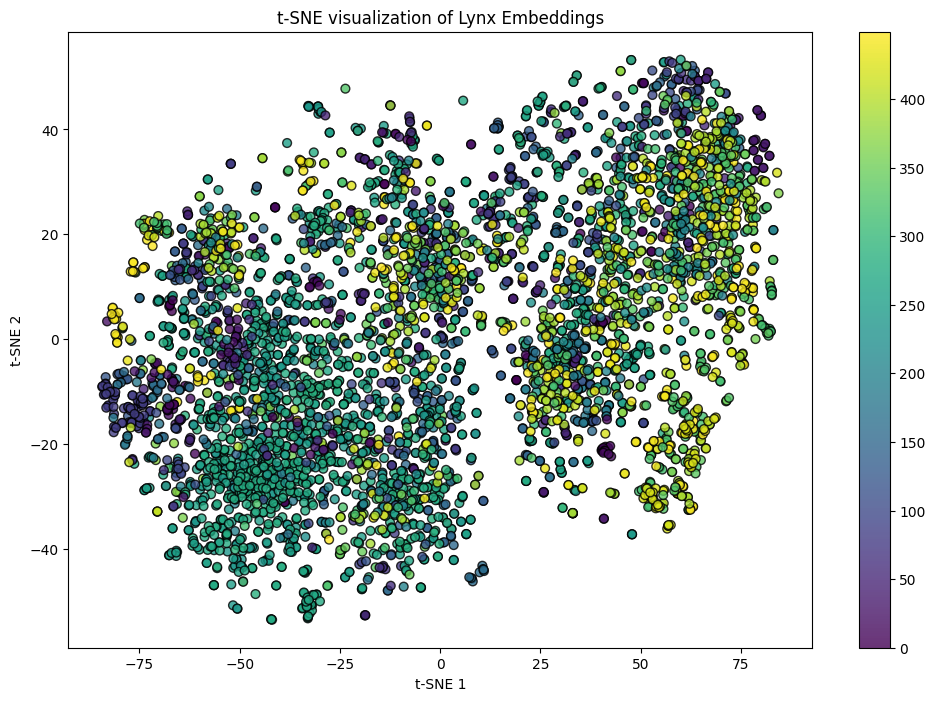

In [15]:
x = dataset.embeddings
y = dataset.lynx_ids

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert embeddings to numpy arrays if they are not already
x = x.numpy() if isinstance(x, torch.Tensor) else x

# Use LabelEncoder to convert lynx names to numeric labels
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Create the t-SNE transformation
tsne = TSNE(n_components=2, random_state=42)

# Transform the embeddings to 2D
x_2d = tsne.fit_transform(x)

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_numeric, cmap='viridis', marker='o', edgecolor='k', s=40, alpha=0.8)
plt.colorbar(scatter)
plt.title("t-SNE visualization of Lynx Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [16]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

# Assuming 'embeddings' is your embeddings tensor and 'y' is an array of lynx names
embeddings_np = dataset.embeddings.numpy()  # Convert to NumPy array if it's a tensor
lynx_names = np.array(dataset.lynx_ids)  # Convert to NumPy array if needed

# Compute pairwise Euclidean distances
distances = euclidean_distances(embeddings_np)

# Initialize variables to compute averages and variances
intra_class_distances = []
inter_class_distances = []

# Iterate over each pair of embeddings
for i in range(len(embeddings_np)):
    for j in range(i + 1, len(embeddings_np)):
        if lynx_names[i] == lynx_names[j]:
            # Intra-class distance
            intra_class_distances.append(distances[i, j])
        else:
            # Inter-class distance
            inter_class_distances.append(distances[i, j])

# Compute the average distances and variances
avg_intra_class_distance = np.mean(intra_class_distances)
avg_inter_class_distance = np.mean(inter_class_distances)
var_intra_class_distance = np.var(intra_class_distances)
var_inter_class_distance = np.var(inter_class_distances)

print(f"Average Intra-Class Distance: {avg_intra_class_distance}")
print(f"Variance Intra-Class Distance: {var_intra_class_distance}")
print(f"Average Inter-Class Distance: {avg_inter_class_distance}")
print(f"Variance Inter-Class Distance: {var_inter_class_distance}")


Average Intra-Class Distance: 21.211435317993164
Variance Intra-Class Distance: 22.423587799072266
Average Inter-Class Distance: 24.084375381469727
Variance Inter-Class Distance: 11.925893783569336


In [17]:
data = dataset[0]
print("data keys are:",data.keys())
for key in data.keys():
    print("key:", key, "got :", data[key].keys())

print("input contains", data["anchor"]["input"].keys())
print("output contains", data["anchor"]["output"].keys())

column_names = dataset.dataframe.columns
print(column_names)


Random positive distance for anchor 0: 25.330259323120117
Random negative distance for anchor 0: 25.5028076171875
data keys are: dict_keys(['anchor', 'positive', 'negative'])
key: anchor got : dict_keys(['input', 'output'])
key: positive got : dict_keys(['input', 'output'])
key: negative got : dict_keys(['input', 'output'])
input contains dict_keys(['image', 'source', 'pattern', 'date', 'location', 'image_number'])
output contains dict_keys(['lynx_id'])
Index(['filepath', 'lynx_id', 'source', 'pattern', 'date', 'location',
       'image_number', 'conf', 'x', 'y', 'width', 'height', 'number_animals',
       'number_children', 'sex', 'side', 'latitude', 'longitude',
       'filepath_no_bg'],
      dtype='object')
